In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
len(X)

1712

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
additional_model.add(layers.Dense(4, activation='softmax'))


additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________


In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_averaging_pooling.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
# class_weight = {0: 1.1,
#                 1: 1.1,
#                 2: 1,
#                 3: 1}

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=200, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/200
43/42 [==============================] - 17s 404ms/step - loss: 1.3860 - acc: 0.2520 - auc: 0.4975 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1000 - val_loss: 1.3853 - val_acc: 0.2770 - val_auc: 0.5102 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1001
Epoch 2/200
43/42 [==============================] - 11s 253ms/step - loss: 1.3847 - acc: 0.2557 - auc: 0.5113 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1002 - val_loss: 1.3858 - val_acc: 0.2770 - val_auc: 0.5168 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1002
Epoch 3/200
43/42 [==============================] - 12s 280ms/step - loss: 1.3843 - acc: 0.2652 - auc: 0.5188 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1003 - val_loss: 1.3854 - val_acc: 0.2449 - val_auc: 0.5181 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1001
Epoch 4/200
43/42 [==============================] - 12s 280ms/step - loss: 1.3856 - acc

Epoch 28/200
43/42 [==============================] - 12s 281ms/step - loss: 1.3839 - acc: 0.2695 - auc: 0.5224 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1003 - val_loss: 1.3853 - val_acc: 0.2770 - val_auc: 0.5224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1002
Epoch 29/200
43/42 [==============================] - 12s 282ms/step - loss: 1.3842 - acc: 0.2695 - auc: 0.5226 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1003 - val_loss: 1.3854 - val_acc: 0.2770 - val_auc: 0.5224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1002
Epoch 30/200
43/42 [==============================] - 12s 281ms/step - loss: 1.3838 - acc: 0.2695 - auc: 0.5224 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1003 - val_loss: 1.3853 - val_acc: 0.2770 - val_auc: 0.5224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1002
Epoch 31/200
43/42 [==============================] - 12s 281ms/step - loss: 1.3839 -

43/42 [==============================] - 12s 276ms/step - loss: 1.3468 - acc: 0.3104 - auc: 0.5473 - precision: 0.4250 - recall: 1.8251e-04 - f1score: 0.1051 - val_loss: 1.3368 - val_acc: 0.3207 - val_auc: 0.5482 - val_precision: 0.4250 - val_recall: 1.8084e-04 - val_f1score: 0.1054
Epoch 56/200
43/42 [==============================] - 12s 277ms/step - loss: 1.3441 - acc: 0.3148 - auc: 0.5489 - precision: 0.4307 - recall: 2.0444e-04 - f1score: 0.1051 - val_loss: 1.3240 - val_acc: 0.3236 - val_auc: 0.5496 - val_precision: 0.4348 - val_recall: 2.0894e-04 - val_f1score: 0.1064
Epoch 57/200
43/42 [==============================] - 12s 278ms/step - loss: 1.3166 - acc: 0.3302 - auc: 0.5508 - precision: 0.4246 - recall: 2.0758e-04 - f1score: 0.1083 - val_loss: 1.3364 - val_acc: 0.2915 - val_auc: 0.5518 - val_precision: 0.4170 - val_recall: 2.1553e-04 - val_f1score: 0.1079
Epoch 58/200
43/42 [==============================] - 12s 281ms/step - loss: 1.3288 - acc: 0.3236 - auc: 0.5527 - precisio

43/42 [==============================] - 12s 277ms/step - loss: 1.0351 - acc: 0.4989 - auc: 0.6296 - precision: 0.5451 - recall: 0.0352 - f1score: 0.1399 - val_loss: 1.0976 - val_acc: 0.4315 - val_auc: 0.6309 - val_precision: 0.5458 - val_recall: 0.0365 - val_f1score: 0.1331
Epoch 84/200
43/42 [==============================] - 12s 281ms/step - loss: 1.0688 - acc: 0.4887 - auc: 0.6322 - precision: 0.5461 - recall: 0.0374 - f1score: 0.1357 - val_loss: 1.1058 - val_acc: 0.4286 - val_auc: 0.6334 - val_precision: 0.5470 - val_recall: 0.0385 - val_f1score: 0.1326
Epoch 85/200
43/42 [==============================] - 12s 281ms/step - loss: 1.0286 - acc: 0.4894 - auc: 0.6347 - precision: 0.5486 - recall: 0.0396 - f1score: 0.1387 - val_loss: 1.0718 - val_acc: 0.4840 - val_auc: 0.6360 - val_precision: 0.5503 - val_recall: 0.0408 - val_f1score: 0.1350
Epoch 86/200
43/42 [==============================] - 12s 281ms/step - loss: 1.0109 - acc: 0.5011 - auc: 0.6373 - precision: 0.5512 - recall: 0.04

43/42 [==============================] - 12s 279ms/step - loss: 0.9067 - acc: 0.5274 - auc: 0.6898 - precision: 0.5779 - recall: 0.1053 - f1score: 0.1519 - val_loss: 1.0812 - val_acc: 0.4606 - val_auc: 0.6906 - val_precision: 0.5779 - val_recall: 0.1064 - val_f1score: 0.1395
Epoch 112/200
43/42 [==============================] - 12s 281ms/step - loss: 0.8966 - acc: 0.5551 - auc: 0.6916 - precision: 0.5784 - recall: 0.1077 - f1score: 0.1533 - val_loss: 1.1443 - val_acc: 0.4402 - val_auc: 0.6924 - val_precision: 0.5789 - val_recall: 0.1091 - val_f1score: 0.1369
Epoch 113/200
43/42 [==============================] - 12s 284ms/step - loss: 0.9077 - acc: 0.5413 - auc: 0.6932 - precision: 0.5792 - recall: 0.1103 - f1score: 0.1513 - val_loss: 1.0188 - val_acc: 0.5510 - val_auc: 0.6940 - val_precision: 0.5796 - val_recall: 0.1115 - val_f1score: 0.1442
Epoch 114/200
43/42 [==============================] - 12s 279ms/step - loss: 0.9080 - acc: 0.5471 - auc: 0.6949 - precision: 0.5803 - recall: 0

43/42 [==============================] - 12s 281ms/step - loss: 0.8201 - acc: 0.5931 - auc: 0.7290 - precision: 0.5966 - recall: 0.1699 - f1score: 0.1607 - val_loss: 1.0253 - val_acc: 0.5015 - val_auc: 0.7296 - val_precision: 0.5970 - val_recall: 0.1711 - val_f1score: 0.1466
Epoch 140/200
43/42 [==============================] - 12s 281ms/step - loss: 0.8219 - acc: 0.6012 - auc: 0.7302 - precision: 0.5973 - recall: 0.1722 - f1score: 0.1607 - val_loss: 1.0224 - val_acc: 0.4985 - val_auc: 0.7309 - val_precision: 0.5975 - val_recall: 0.1733 - val_f1score: 0.1469
Epoch 141/200
43/42 [==============================] - 12s 281ms/step - loss: 0.8026 - acc: 0.6092 - auc: 0.7315 - precision: 0.5979 - recall: 0.1744 - f1score: 0.1626 - val_loss: 1.0955 - val_acc: 0.4927 - val_auc: 0.7321 - val_precision: 0.5983 - val_recall: 0.1756 - val_f1score: 0.1444
Epoch 142/200
43/42 [==============================] - 12s 280ms/step - loss: 0.8375 - acc: 0.5800 - auc: 0.7326 - precision: 0.5986 - recall: 0

43/42 [==============================] - 12s 281ms/step - loss: 0.7311 - acc: 0.6552 - auc: 0.7576 - precision: 0.6130 - recall: 0.2263 - f1score: 0.1710 - val_loss: 1.0800 - val_acc: 0.5131 - val_auc: 0.7580 - val_precision: 0.6135 - val_recall: 0.2273 - val_f1score: 0.1469
Epoch 168/200
43/42 [==============================] - 12s 281ms/step - loss: 0.7597 - acc: 0.6392 - auc: 0.7585 - precision: 0.6139 - recall: 0.2283 - f1score: 0.1680 - val_loss: 1.1544 - val_acc: 0.4927 - val_auc: 0.7589 - val_precision: 0.6141 - val_recall: 0.2292 - val_f1score: 0.1422
Epoch 169/200
43/42 [==============================] - 12s 279ms/step - loss: 0.7566 - acc: 0.6560 - auc: 0.7594 - precision: 0.6145 - recall: 0.2302 - f1score: nan - val_loss: 1.0650 - val_acc: 0.5335 - val_auc: 0.7598 - val_precision: 0.6148 - val_recall: 0.2311 - val_f1score: 0.1485
Epoch 170/200
43/42 [==============================] - 12s 279ms/step - loss: 0.7427 - acc: 0.6399 - auc: 0.7602 - precision: 0.6151 - recall: 0.23

43/42 [==============================] - 12s 280ms/step - loss: 0.7333 - acc: 0.6654 - auc: 0.7801 - precision: 0.6289 - recall: 0.2754 - f1score: nan - val_loss: 1.0444 - val_acc: 0.5627 - val_auc: 0.7805 - val_precision: 0.6291 - val_recall: 0.2761 - val_f1score: 0.1512
Epoch 196/200
43/42 [==============================] - 12s 280ms/step - loss: 0.6825 - acc: 0.6844 - auc: 0.7808 - precision: 0.6294 - recall: 0.2769 - f1score: nan - val_loss: 1.0784 - val_acc: 0.5569 - val_auc: 0.7812 - val_precision: 0.6298 - val_recall: 0.2778 - val_f1score: 0.1514
Epoch 197/200
43/42 [==============================] - 12s 281ms/step - loss: 0.6536 - acc: 0.6976 - auc: 0.7816 - precision: 0.6302 - recall: 0.2786 - f1score: 0.1791 - val_loss: 1.1302 - val_acc: 0.5423 - val_auc: 0.7820 - val_precision: 0.6305 - val_recall: 0.2795 - val_f1score: 0.1500
Epoch 198/200
43/42 [==============================] - 12s 280ms/step - loss: 0.6701 - acc: 0.6749 - auc: 0.7824 - precision: 0.6307 - recall: 0.2803 

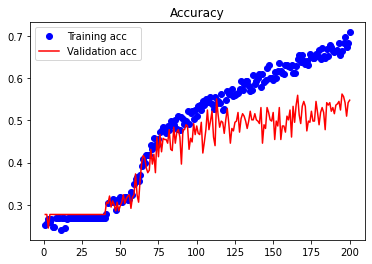

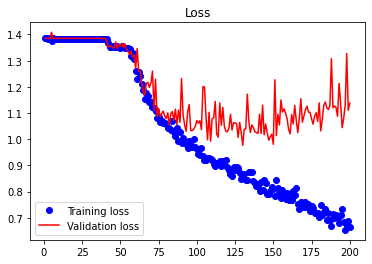

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.138, accuracy: 0.548, auc: 0.784, precision: 0.632, recall: 0.285, f1score: 0.146


In [17]:
from keras.models import Model, load_model

new_model = models.load_model('./VGG16_averaging_pooling.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [18]:
X_test=np.load('X_val.npy')
y_test=np.load('y_val.npy')

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

571/571 [==============================] - 3s 5ms/step
loss: 0.993, accuracy: 0.497, auc: 0.808, precision: 0.530, recall: 0.397, f1score: 0.147
